# MMDetection tutorial 참고
[Ref](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb) 

In [1]:
# Installing mmcv-full
!pip install mmcv-full

# Installing mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

# Kernel should be restarted!!!!

     |████████████████████████████████| 352 kB 8.0 MB/s 
     |████████████████████████████████| 313 kB 14.7 MB/s 
     |████████████████████████████████| 185 kB 18.0 MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.9-cp37-cp37m-linux_x86_64.whl size=29313866 sha256=9e0811ed974b1f5ceba836a43512e526f61828791ba7736bfcaea38b8299ec43
  Stored in directory: /root/.cache/pip/wheels/2f/4b/7a/180870186c89ce617e1935c9ac9e4d13e643782327434b7349
Successfully built mmcv-full
Cloning into 'mmdetection'...
remote: Enumerating objects: 20147, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 20147 (delta 273), reused 353 (delta 249), pack-reused 19729
Receiving objects: 100% (20147/20147), 24.00 MiB | 25.12 MiB/s, done.
Resolving deltas: 100% (14039/14039), done.
running install
running bdist_egg
running egg_info
creating mmdet.egg-info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_

In [1]:
from mmdet.apis import init_detector, inference_detector
import mmcv

# Download KITTI Dataset 
- 작은 용량의 KITTI dataset 을 다운로드하고(kitti_tiny) /content 밑에 압축 해제

In [2]:
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2021-07-30 17:28:55--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.78
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  8.11MB/s    in 0.8s    

2021-07-30 17:28:57 (8.11 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



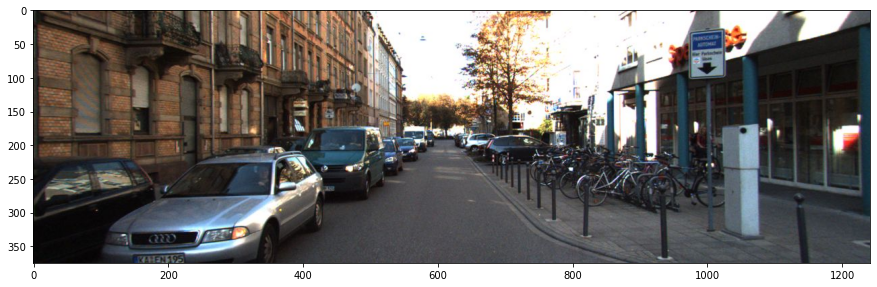

In [3]:
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,10))
plt.imshow(img)

## KITTI DATA FORMAT 확인
- 첫 번째 컬럼은 해당 object의 class name
- 5 ~ 8 번째 컬럼이 Bounding box 정보: 좌상단(x_min, y_min), 우하단(x_max, y_max)

In [4]:
!cat /content/kitti_tiny/training/label_2/000068.txt

Car 0.25 0 1.94 69.26 200.28 435.08 374.00 1.46 1.62 4.04 -3.00 1.79 6.98 1.55
Car 0.80 1 2.26 0.00 209.20 198.59 374.00 1.46 1.58 3.72 -5.44 1.85 6.22 1.56
Cyclist 0.97 0 2.34 1210.28 199.77 1241.00 374.00 1.55 0.57 1.73 4.04 1.69 3.57 -3.14
Car 0.00 2 1.68 478.18 187.68 549.54 249.43 1.57 1.60 3.99 -2.73 2.03 20.96 1.55
Car 0.00 1 1.66 530.03 187.79 573.10 226.09 1.52 1.54 3.68 -2.53 2.20 31.50 1.58
Van 0.00 1 1.63 547.61 171.12 584.05 212.41 2.47 1.98 5.81 -2.79 2.41 46.44 1.57
Car 0.00 1 -0.16 667.74 182.35 790.82 230.38 1.62 1.65 4.14 4.19 1.99 25.95 0.00
Car 0.00 2 -0.11 657.37 184.48 763.34 221.64 1.55 1.66 4.47 4.35 2.10 32.00 0.02
Car 0.00 1 -0.01 637.45 180.34 714.44 212.34 1.69 1.76 4.12 3.59 2.12 39.79 0.08
Van 0.00 1 1.61 572.52 175.02 596.26 199.95 2.13 1.91 6.40 -2.28 2.36 65.43 1.57
Van 0.00 1 1.77 380.78 167.69 523.29 288.56 1.95 1.75 4.63 -2.89 1.90 14.05 1.57
Cyclist 0.00 1 1.09 958.95 167.55 1036.88 254.43 1.68 0.53 1.96 7.95 1.59 14.95 1.57


- KITTI annotation file 들의 리스트 확인 (train.txt)

In [5]:
!cat /content/kitti_tiny/train.txt

000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049


## mmdetection의 중립(mid?) annotation 포맷 변환. 
- 해당 포맷은 텍스트로 변환하지 않고, 바로 메모리 상의 list로 생성됨.
- `filename`, `width`, `height`, `ann` 을 Key 로 가지는 dictionary 를 이미지 갯수 대로 가지는 list 생성
    - `filename`: 이미지 파일명(디렉토리는 포함하지 않음)
    - `width`: 이미지 너비
    - `height`: 이미지 높이
    - `ann`: bounding box와 label에 대한 정보를 가지고 있는 dictionary
        - `bboxes`: 하나의 이미지에 있는 여러 object 들의 numpy array. 4개의 좌표값(좌상단, 우하단)을 가지고, 해당 이미지에 N개의 object들이 있을 경우 array의 shape은 (n, 4)
        - `labels`: 하나의 이미지에 있는 여러 object들의 numpy array. shape은 (n, )
        - `bboxes_ignore`: 학습에 사용되지 않고 무시하는 bboxes. 무시하는 bboxes의 갯수가 k개이면 shape은 (k, 4)
        - `lables_ignore`: 학습에 사용되지 않고 무시하는 labels. 무시하는 labels의 갯수가 k개이면 shape은 (k,)
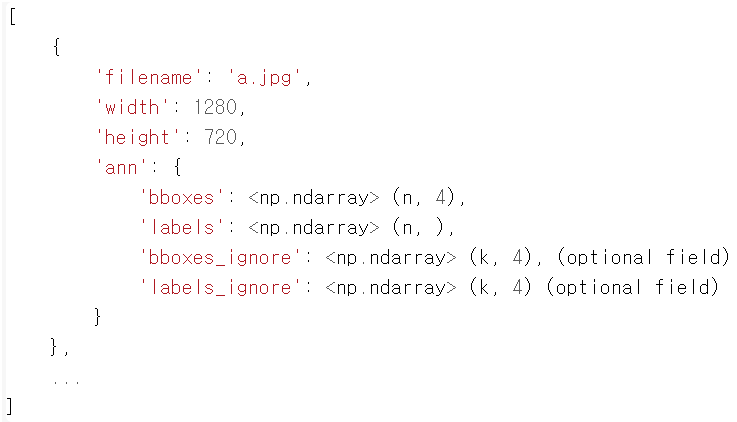

## KITTI Dataset을 중립 데이터 형대로 변환하여 메모리 로드
- 원본 KITTI Dataset은 10개의 class로 되어 있음. 
- Car, Van, Truck, Pedestrian, Person_sitting Cyclist, Tram, Misc, DontCare

In [6]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}
print(cat2label)
print(cat2label['Car'])

{'Car': 0, 'Truck': 1, 'Pedestrian': 2, 'Cyclist': 3}
0


In [7]:
image_list = mmcv.list_from_file('/content/kitti_tiny/train.txt')
print(image_list)

['000000', '000001', '000002', '000003', '000004', '000005', '000006', '000007', '000008', '000009', '000010', '000011', '000012', '000013', '000014', '000015', '000016', '000017', '000018', '000019', '000020', '000021', '000022', '000023', '000024', '000025', '000026', '000027', '000028', '000029', '000030', '000031', '000032', '000033', '000034', '000035', '000036', '000037', '000038', '000039', '000040', '000041', '000042', '000043', '000044', '000045', '000046', '000047', '000048', '000049']


In [8]:
lines = mmcv.list_from_file('/content/kitti_tiny/training/label_2/000064.txt')
print(lines)

['Car 0.00 0 -1.70 657.65 179.93 709.86 219.92 1.38 1.49 3.32 2.65 1.65 26.82 -1.60', 'Car 0.00 0 -1.85 731.51 180.39 882.28 275.80 1.50 1.62 3.89 3.43 1.65 13.46 -1.60', 'Car 0.00 1 -1.83 715.18 175.63 762.77 203.90 1.44 1.56 3.96 6.91 1.61 39.17 -1.65', 'Truck 0.00 1 -2.01 816.58 59.74 1112.51 266.07 3.55 2.56 7.97 7.25 1.64 16.44 -1.60', 'DontCare -1 -1 -10 626.78 174.27 647.77 192.18 -1 -1 -1 -1000 -1000 -1000 -10', 'DontCare -1 -1 -10 546.19 168.97 554.01 177.09 -1 -1 -1 -1000 -1000 -1000 -10']


In [9]:
content = [line.strip().split(' ') for line in lines]
bbox_names = [x[0] for x in content]
print(bbox_names)

['Car', 'Car', 'Car', 'Truck', 'DontCare', 'DontCare']


In [10]:
bboxes = [[float(info) for info in x[4:8]] for x in content]
print(bboxes)

[[657.65, 179.93, 709.86, 219.92], [731.51, 180.39, 882.28, 275.8], [715.18, 175.63, 762.77, 203.9], [816.58, 59.74, 1112.51, 266.07], [626.78, 174.27, 647.77, 192.18], [546.19, 168.97, 554.01, 177.09]]


In [11]:
import copy
import os.path as osp
import cv2
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# Decorator 설정 필수!! @DATASETS.register_module() 설정 시 force=True  필수. 입력 하지 않으면 Dataset 재등록 불가.
@DATASETS.register_module(force=True)
class KittyTinyDataset(CustomDataset):
    CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')

    '''__init__을 그대로 상속 받음.
    self.data_root: /content/kitti_tiny/ 
    self.ann_file: /content/kitti_tiny/train.txt 
    self.img_prefix: /content/kitti_tiny/training/image_2
    
    ann_file: /content/kitti_tiny/train.txt
    '''
    # annotation에 대한 모든 파일명을 가지고 있는 텍스트 파일을 __init__(self, ann_file)로 입력 받고,
    # 이 self.ann_file이 load_annotations()의 인자로 입력됨.
    def load_annotations(self, ann_file):
        print('##### self.data_root:', self.data_root, 'self.ann_file:', self.ann_file, 'self.img_prefix:', self.img_prefix)
        print('#### ann_file:', ann_file)
        cat2label = {k:i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
        # 중립 포맷 데이터를 담은 list 객체
        data_infos = []

        for image_id in image_list:
            filename = '{0:}/{1:}.jpeg'.format(self.img_prefix, image_id)
            # 원본 이미지의 너비, 높이를 image를 직접 로드해서 구함.
            image = cv2.imread(filename)
            height, width = image.shape[:2]

            # 개별 image의 annotation 정보 저장용 dictionary 생성. key값 filename에는 image의 파일명만 들어감(디렉토리 제외!!)
            data_info = {'filename': str(image_id) + '.jpeg', 'width': width, 'height': height}

            # 개별 annotation이 있는 서브 디렉토리의 prefix 변환
            label_prefix = self.img_prefix.replace('image_2', 'label_2')

            # 개별 annotation 파일을 1개 line 씩 읽어서 list 로드
            lines = mmcv.list_from_file(osp.join(label_prefix, str(image_id)+'.txt'))

            # 전체 lines를 개별 line별 공백 레벨로 parsing 해서 다시 list로 저장. content는 list의 list 형태임.
            # ann 정보는 numpy array 로 저장되나 텍스트 처리나 데이터 가공이 list가 편하기 때문에 list로 변환함.
            content = [line.strip().split(' ') for line in lines]

            # 오브젝트의 클래스 명은 bbox_names 로 저장
            bbox_names = [x[0] for x in content]

            # bbox 좌표 저장 = bboxes
            bboxes = [[float(info) for info in x[4:8]] for x in content]

            # 클래스 명이 해당 사항이 없는 대상 filtering out. 
            # 'DontCare'는 ignore로 별도 저장.
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []

            for bbox_name, bbox in zip(bbox_names, bboxes):
                # 만약 bbox_name 이 클래스 명에 해당되면, gt_bboxes와 gt_labels에 추가하고, 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
                if bbox_name in cat2label:
                    gt_bboxes.append(bbox)
                    # gt_labels 에는 class id 입력
                    gt_labels.append(cat2label[bbox_name])

                else:
                    gt_bboxes_ignore.append(bbox)
                    gt_labels_ignore.append(-1)
            # 개별 image별 annotation 정보를 가지는 dictionary 생성. 해당 dictionary의 value 값은 모두 np.array임.
            data_anno = {
                'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                'labels': np.array(gt_labels, dtype=np.long),
                'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
                'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
            }

            # image에 대한 메타 정보를 가지는 data_infor dictionary에 'ann' key 값으로 data_anno를 value에 저장
            data_info.update(ann=data_anno)

            # 전체 annotation 파일들에 대한 정보를 가지는 data_infors에 data_info dictionary 추가
            data_infos.append(data_info)

        return data_infos

## Config 설정 및 pretrained model 다운로드

In [12]:
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [13]:
!cd mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2021-07-30 17:29:09--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.78
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  11.1MB/s    in 15s     

2021-07-30 17:29:24 (10.7 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [14]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [15]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정.
cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

# class의 갯수 수정
cfg.model.roi_head.bbox_head.num_classes = 4

# pretrained model
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정
cfg.work_dir = './tutorial_exps'

# 학습 환경 파라미터 설정
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# config 수행 시마다 policy 값이 없어지는 버그로 인해 설정
cfg.lr_config.policy = 'step'

# Evaluation metric 변경
cfg.evaluation.metric = 'mAP'

# Evaluation 시간을 줄이기 위해서 evaluation interval을 정함
cfg.evaluation.interval = 12

# Storage cost를 줄이기 위해 checkpoint saving interval 정함
cfg.checkpoint_config.interval = 12

# Seed 정함
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# initialize the logger for training and have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

## Config 에서 설정한 dataset과 model, learning rate, pipeline 설정에 따라 모델 학습 수행
- train용 dataset을 생성하고 이를 이용해서 학습 수행.

In [16]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]

##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/train.txt


/usr/local/lib/python3.7/dist-packages/mmdet-2.14.0-py3.7.egg/mmdet/datasets/custom.py:156: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')


In [17]:
datasets

[
 KittyTinyDataset Train dataset with number of images 50, and instance counts: 
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | category | count | category  | count | category       | count | category    | count | category      | count |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | 0 [Car]  | 147   | 1 [Truck] | 7     | 2 [Pedestrian] | 23    | 3 [Cyclist] | 7     | -1 background | 0     |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+]

In [18]:
datasets[0].CLASSES

('Car', 'Truck', 'Pedestrian', 'Cyclist')

In [19]:
model = build_detector(cfg.model, train_cfg = cfg.get('train_cfg'), test_cfg = cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

/usr/local/lib/python3.7/dist-packages/mmdet-2.14.0-py3.7.egg/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


In [20]:
# 주의, config에 pretrained 모델 지정이 상대 경로로 설정됨 
# cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# 아래와 같이 %cd mmdetection 지정 필요. 
%cd mmdetection

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# epochs는 config의 runner 파라미터로 지정됨. 기본 12회.
train_detector(model, datasets, cfg, distributed=False, validate=True)

/content/mmdetection


2021-07-30 17:29:52,985 - mmdet - INFO - load checkpoint from checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2021-07-30 17:29:52,987 - mmdet - INFO - Use load_from_local loader


##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/val.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/val.txt


2021-07-30 17:29:53,115 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
2021-07-30 17:29:53,119 - mmdet - INFO - Start running, host: root@7049cc050986, work_dir: /content/mmdetection/tutorial_exps
2021-07-30 17:29:53,122 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH  

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 11.1 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-07-30 17:32:08,063 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 153  | 0.919  | 0.805 |
| Truck      | 3   | 21   | 1.000  | 0.600 |
| Pedestrian | 13  | 56   | 0.923  | 0.777 |
| Cyclist    | 7   | 51   | 0.571  | 0.151 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.583 |
+------------+-----+------+--------+-------+
2021-07-30 17:32:08,066 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5830, mAP: 0.5832


## 학습된 model을 이용하여 inference 수행

/usr/local/lib/python3.7/dist-packages/mmdet-2.14.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet-2.14.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


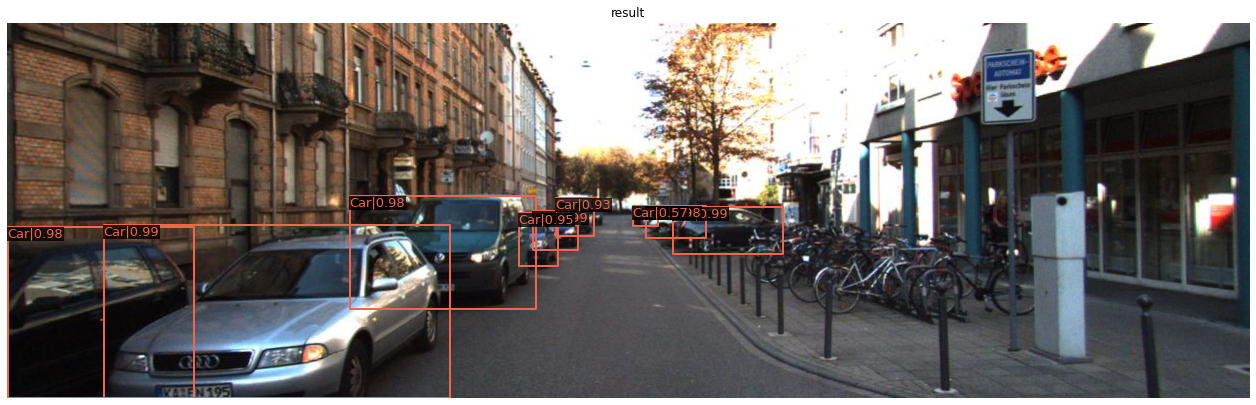

In [25]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

## 학습된 모델을 이용하여 video detection 수행하기
- 앞선 practice와 유사함

In [26]:
%cd /content
!mkdir /content/data
!wget -O /content/data/the_rock_chase.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true

/content
--2021-07-30 17:36:14--  https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/the_rock_chase.mp4 [following]
--2021-07-30 17:36:14--  https://github.com/chulminkw/DLCV/raw/master/data/video/the_rock_chase.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/the_rock_chase.mp4 [following]
--2021-07-30 17:36:14--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/the_rock_chase.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [27]:
CLASSES = {'Car', 'Truck', 'Pedestrian', 'Cyclist'}
labels_to_names_seq = {i:k for i, k in enumerate(CLASSES)}
labels_to_names_seq

{0: 'Cyclist', 1: 'Pedestrian', 2: 'Car', 3: 'Truck'}

In [28]:
cat2label = {k:i for i, k in enumerate(CLASSES)}

def get_detected_img(model, img_array, score_threshold=0.3, is_print=True):
    # 인자로 들어온 Image array 먼저 복사해서 꼬이지 않게 하자.
    draw_img = img_array.copy()
    bbox_color = (0, 255, 0)
    text_color = (0, 0, 255)

    # model 과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음
    # results 는 80개의 2차원 array(shape=(오브젝트 갯수, 5)) 를 가지는 list 임.
    results = inference_detector(model, img_array)

    # 80개의 array 원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화
    # results 리스트의 '위치 index'가 COCO에서 맵핑된 class_id 임. 여기서는 result_idx = class_id
    # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐.
    for result_idx, result in enumerate(results):
        # 개별 2차원 array의 row size가 0 이면, 해당 class_id 값이 없으므로 다음 loop 진행(coco 데이터셋 특징)
        if len(result) == 0:
            continue
        
        # 2차원 array에서 5번째 컬럼에 해당하는 값이 score_threshold 이미 이 값이 함수 인자로 들어온 score_threshold 보다 낮은 경우 제외.
        result_filtered = result[np.where(result[:,4] > score_threshold)]

        # 해당 클래스 별로 detect된 여러 개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이것(2차원 array)을 row 수 만큼 iteration해서 개별 오브젝트의 좌표값 추출.
        for i in range(len(result_filtered)):
            # 좌상단, 우하단 좌표 추출
            left = int(result_filtered[i, 0])
            top = int(result_filtered[i, 1])
            right = int(result_filtered[i, 2])
            bottom = int(result_filtered[i, 3])

            caption = "{}: {:.4f}".format(labels_to_names_seq[result_idx], result_filtered[i, 4])

            cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top-7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)

            if is_print:
                print(caption)
    return draw_img

In [29]:
import time

def get_detected_video(model, input_path, output_path, score_threshold, do_print=True):
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 frame count: ', frame_cnt)

    btime = time.time()
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        stime = time.time()
        img_frame = get_detected_img(model, img_frame, score_threshold, is_print=False)
        if do_print:
            print('frame별 detection 수행 시간: ', round(time.time() - stime, 4))
        vid_writer.write(img_frame)

    
    vid_writer.release()
    cap.release()

    print('최종 Detection 완료 수행 시간: ', round(time.time() - btime, 4))

In [30]:
get_detected_video(model, '/content/data/the_rock_chase.mp4', '/content/data/the_rock_chase_out1.mp4', 0.4, do_print=True)

총 frame count:  503
frame별 detection 수행 시간:  0.1805


/usr/local/lib/python3.7/dist-packages/mmdet-2.14.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet-2.14.0-py3.7.egg/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


frame별 detection 수행 시간:  0.1429
frame별 detection 수행 시간:  0.1178
frame별 detection 수행 시간:  0.1161
frame별 detection 수행 시간:  0.1193
frame별 detection 수행 시간:  0.1192
frame별 detection 수행 시간:  0.1158
frame별 detection 수행 시간:  0.1164
frame별 detection 수행 시간:  0.1158
frame별 detection 수행 시간:  0.1145
frame별 detection 수행 시간:  0.1149
frame별 detection 수행 시간:  0.1148
frame별 detection 수행 시간:  0.114
frame별 detection 수행 시간:  0.1139
frame별 detection 수행 시간:  0.1136
frame별 detection 수행 시간:  0.1151
frame별 detection 수행 시간:  0.1165
frame별 detection 수행 시간:  0.1131
frame별 detection 수행 시간:  0.1192
frame별 detection 수행 시간:  0.1183
frame별 detection 수행 시간:  0.1166
frame별 detection 수행 시간:  0.116
frame별 detection 수행 시간:  0.1175
frame별 detection 수행 시간:  0.1188
frame별 detection 수행 시간:  0.118
frame별 detection 수행 시간:  0.1175
frame별 detection 수행 시간:  0.1162
frame별 detection 수행 시간:  0.1165
frame별 detection 수행 시간:  0.1173
frame별 detection 수행 시간:  0.1218
frame별 detection 수행 시간:  0.1137
frame별 detection 수행 시간:  0.1153
frame별 dete